# Airplane Capital Budgeting Monte Carlo Problem

# The Basic Model

Before we get to the Monte Carlo part or bringing in any of the distributions, we just want to be able to get the base NPV for a plane. To get there, we will need to find the cash flows of the plane. We already have the research and manufacture costs as our $t=0$ and $t=1$ cash flows. So then it's just figuring out the $t=2$ cash flow. 

## Setup

The required packages are imported.

In [1]:
import numpy as np
from dataclasses import dataclass
import random
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

## Inputs

In this model, we will be modeling three planes separately. So I will set up the overall model inputs, as well as the inputs for a particular plane.

In [2]:
@dataclass
class PlaneInputs:
    name: str = 'Super Size'
    num_units: int = 200
    num_units_mean: int = 200
    num_units_std: float = 120
    price: float = 11500000
    research_cost: float = 100000000
    manufacture_cost: float = 10000000
        

@dataclass
class ModelInputs:
    planes: tuple = (
        PlaneInputs(
            name='Super Size',
            num_units=200,
            num_units_mean=200,
            num_units_std=120,
            price=11500000,
            research_cost=100000000,
            manufacture_cost=10000000,
        ),
        PlaneInputs(
            name='Large',
            num_units=400,
            num_units_mean=400,
            num_units_std=50,
            price=5600000,
            research_cost=50000000,
            manufacture_cost=5000000,
        ),
        PlaneInputs(
            name='Mid-Size',
            num_units=500,
            num_units_mean=500,
            num_units_std=20,
            price=33500000,
            research_cost=25000000,
            manufacture_cost=3000000,
        )
    )
    interest_rate: float = 0.07
    interest_rate_mean: float = 0.07
    interest_rate_std: float = 0.04
    num_simulations: int = 10000
        
model_data = ModelInputs()
model_data

ModelInputs(planes=(PlaneInputs(name='Super Size', num_units=200, num_units_mean=200, num_units_std=120, price=11500000, research_cost=100000000, manufacture_cost=10000000), PlaneInputs(name='Large', num_units=400, num_units_mean=400, num_units_std=50, price=5600000, research_cost=50000000, manufacture_cost=5000000), PlaneInputs(name='Mid-Size', num_units=500, num_units_mean=500, num_units_std=20, price=33500000, research_cost=25000000, manufacture_cost=3000000)), interest_rate=0.07, interest_rate_mean=0.07, interest_rate_std=0.04, num_simulations=10000)

To help put together the functions and show examples, also take the plane inputs separately.

In [3]:
plane = PlaneInputs()
plane

PlaneInputs(name='Super Size', num_units=200, num_units_mean=200, num_units_std=120, price=11500000, research_cost=100000000, manufacture_cost=10000000)

## Getting the $t=2$ Cash Flow

For this cash flow, it will simply be: $$\pi = PQ$$ Where $\pi$ is the profit, $P$ is the price, and $Q$ is the quantity of planes sold.

In [4]:
profit = plane.price * plane.num_units
profit

2300000000

## Putting the Cash Flows Together

At $t=0$, we pay the research cost, and at $t=1$, we pay the manufacture cost. Just add the $t=2$ cash flow we added to these and we will have all the cash flows for the plane.

In [5]:
cash_flows = [
    -plane.research_cost,
    -plane.manufacture_cost * plane.num_units,
    profit
]
cash_flows

[-100000000, -2000000000, 2300000000]

## Calculating NPV

`numpy` has an NPV function to calculate this for us. Recall that `numpy`'s NPV function expects the first cash flow to be period 0, which is what we have, so we can pass the cash flows directly in.

In [6]:
np.npv(model_data.interest_rate, cash_flows)

/home/nick/.local/share/virtualenvs/fin-model-course-eIFMSc8A/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: numpy.npv is deprecated and will be removed from NumPy 1.20. Use numpy_financial.npv instead (https://pypi.org/project/numpy-financial/).
  """Entry point for launching an IPython kernel.


39750196.52371383

Now let's put all the preceding steps in a function for later use.

In [7]:
def plane_cash_flows(plane):
    """
    Calculates the expected profit from a plane as units muliplied by price,
    then puts together cash flows which include first paying a research cost,
    then a manuafacturing cost, then earning the profit.
    """
    profit = plane.price * plane.num_units
    cash_flows = [
        -plane.research_cost,
        -plane.manufacture_cost * plane.num_units,
        profit
    ]
    return cash_flows


def plane_npv(data, plane):
    """
    Uses the plane_cash_flows function to determine cash flows of a plane,
    then calculates the NPV from those cash flows and the interest rate.
    """
    cash_flows = plane_cash_flows(plane)
    npv = np.npv(data.interest_rate, cash_flows)
    return npv

plane_npv(model_data, plane)

/home/nick/.local/share/virtualenvs/fin-model-course-eIFMSc8A/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: numpy.npv is deprecated and will be removed from NumPy 1.20. Use numpy_financial.npv instead (https://pypi.org/project/numpy-financial/).


39750196.52371383

# Monte Carlo Simulations

## Getting Random Interest Rates and Units

Now we have the basic model set up. Now for each type of plane, we want to assign a distribution to both the number of units sold and the interest rate. For interest rate, it is straightforward to pull it from a normal distribution. For the units, we have some additional complications discussed below.

In [8]:
interest_rate = random.normalvariate(model_data.interest_rate_mean, model_data.interest_rate_std)
interest_rate

0.07073732751344351

One snag with the units is we can't sell a partial plane. So we'll also round it. Further, we can't sell negative planes, so we will take the max of 0 and the number of planes.

In [9]:
num_units = random.normalvariate(plane.num_units_mean, plane.num_units_std)
num_units

164.80445947079468

In [10]:
round(num_units)

165

In [11]:
max(0, round(num_units))

165

Now put this all into a function.

In [12]:
def random_interest_num_units(data, plane):
    """
    Gets a random interest rate and number of plane units.
    
    Both are drawn from normal distributions. For number of units, it is also
    rounded and set to 0 if it is negative.
    """
    interest_rate = random.normalvariate(data.interest_rate_mean, data.interest_rate_std)
    num_units = random.normalvariate(plane.num_units_mean, plane.num_units_std)
    num_units = max(0, round(num_units))
    return interest_rate, num_units

random_interest_num_units(model_data, plane)

(0.08341294704424548, 0)

## Running a Simulation

To run one simulation, we need to pick those random values for units and interest rate and then pass them into the plane and collect the NPV. As you run this multiple times, you can see the NPV change.

In [13]:
interest_rate, num_units = random_interest_num_units(model_data, plane)
plane.num_units = num_units
model_data.interest_rate = interest_rate
npv = plane_npv(model_data, plane)
npv

/home/nick/.local/share/virtualenvs/fin-model-course-eIFMSc8A/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: numpy.npv is deprecated and will be removed from NumPy 1.20. Use numpy_financial.npv instead (https://pypi.org/project/numpy-financial/).


57247210.08716822

We're going to have to run this for each plane 10,000 times. So let's make a function for this to stay organized. We also want to return the interest rate and number of units used for later analysis.

In [14]:
def plane_simulation(data, plane):
    """
    Runs a single Monte Carlo simulation for a single plane.
    
    Varies the interest rate and number of units according to normal
    distributions with each simulation.
    """
    interest_rate, num_units = random_interest_num_units(data, plane)
    plane.num_units = num_units
    model_data.interest_rate = interest_rate
    npv = plane_npv(data, plane)
    return interest_rate, num_units, npv

plane_simulation(model_data, plane)

/home/nick/.local/share/virtualenvs/fin-model-course-eIFMSc8A/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: numpy.npv is deprecated and will be removed from NumPy 1.20. Use numpy_financial.npv instead (https://pypi.org/project/numpy-financial/).


(0.03948724626200871, 97, -792203.2977284193)

## Running all the Simulations for One Plane

Now we have a function that runs a single simulation for a single plane. So now we want to run 10,000 of these for that plane.

In [15]:
outputs = [plane_simulation(model_data, plane) for i in range(model_data.num_simulations)]

/home/nick/.local/share/virtualenvs/fin-model-course-eIFMSc8A/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: numpy.npv is deprecated and will be removed from NumPy 1.20. Use numpy_financial.npv instead (https://pypi.org/project/numpy-financial/).


In [16]:
outputs[:5]

[(0.022925576320880547, 268, 225465431.49248838),
 (0.14223210622618038, 282, -83210272.029634),
 (0.010165939715250996, 117, 60329481.38494372),
 (0.004884234935234585, 442, 535191677.84482193),
 (0.06228690381323236, 124, -3616549.0670495033)]

In [17]:
len(outputs)

10000

Everything looks right, so now let's put it into a `DataFrame`.

In [18]:
df = pd.DataFrame(
    outputs,
    columns=['Interest Rate', 'Number of Units Sold', 'NPV']
)

df.head()  # view first rows

,Interest Rate,Number of Units Sold,NPV
0,0.022926,268,2.254654e+08
1,0.142232,282,-8.321027e+07
2,0.010166,117,6.032948e+07
3,0.004884,442,5.351917e+08
4,0.062287,124,-3.616549e+06


Let's add some styling to these `DataFrames` as well.

In [19]:
def styled_df(df):
    """
    Add formatting to a simulation DataFrame
    """
    return df.style.format({
        'Interest Rate': '{:.1%}',
        'Number of Units Sold': '{:,.0f}',
        'NPV': '${:,.0f}'
    }).background_gradient(cmap='RdYlGn', subset='NPV')

styled_df(df.head())

,Interest Rate,Number of Units Sold,NPV
0,2.3%,268,"$225,465,431"
1,14.2%,282,"$-83,210,272"
2,1.0%,117,"$60,329,481"
3,0.5%,442,"$535,191,678"
4,6.2%,124,"$-3,616,549"


In [20]:
len(df)

10000

In [21]:
styled_df(df.describe().drop('count'))

,Interest Rate,Number of Units Sold,NPV
mean,7.0%,201,"$47,746,010"
std,4.0%,115,"$127,118,199"
min,-8.5%,0,"$-222,437,343"
25%,4.2%,117,"$-47,041,083"
50%,7.0%,199,"$20,990,563"
75%,9.6%,279,"$113,355,723"
max,23.5%,649,"$1,024,107,578"


Everything looks right. So now let's wrap this up in a function.

In [22]:
def plane_simulations(data, plane):
    """
    Runs all the simulations for a given plane, and outputs the results to a DataFrame
    
    Uses the plane_simulation function to run each simulation.
    """
    outputs = [plane_simulation(data, plane) for i in range(data.num_simulations)]
    df = pd.DataFrame(
        outputs,
        columns=['Interest Rate', 'Number of Units Sold', 'NPV']
    )
    return df

df = plane_simulations(model_data, plane)
styled_df(df.head())

/home/nick/.local/share/virtualenvs/fin-model-course-eIFMSc8A/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: numpy.npv is deprecated and will be removed from NumPy 1.20. Use numpy_financial.npv instead (https://pypi.org/project/numpy-financial/).


,Interest Rate,Number of Units Sold,NPV
0,9.2%,40,"$-80,475,048"
1,11.3%,275,"$-17,602,811"
2,15.4%,198,"$-105,350,807"
3,7.4%,316,"$106,707,694"
4,5.9%,87,"$-28,957,592"


# Visualizing and Analyzing Simulations

## Expected NPV and Standard Deviation of NPV

In [23]:
df['NPV'].mean()  # expected NPV

50829037.467981674

In [24]:
df['NPV'].std()  # stdev of NPV

127729724.07202509

## NPV Visualization

### Plotting

We can use a histogram to visualize the probability distribution of the NPV.

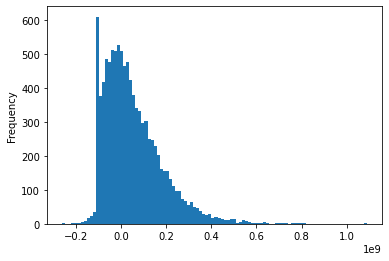

In [25]:
%matplotlib inline
df['NPV'].plot.hist(bins=100)

We can see for this "test plane" that the NPV will usually be somewhere between -500 and 1,000, with the most likely being -500. The distribution is highly skewed to the left.

### Probability Table

In [26]:
styled_df(df.quantile([i/20 for i in range(1, 20)]))

,Interest Rate,Number of Units Sold,NPV
0.05,0.4%,3,"$-100,000,000"
0.1,1.8%,47,"$-87,693,668"
0.15,2.8%,76,"$-71,309,161"
0.2,3.6%,101,"$-57,449,231"
0.25,4.2%,120,"$-43,569,431"
0.3,4.8%,138,"$-30,060,082"
0.35,5.4%,155,"$-17,163,479"
0.4,5.9%,171,"$-4,100,158"
0.45,6.4%,186,"$9,176,607"
0.5,6.9%,202,"$23,650,582"


## Chance of Positive/Negative NPV

We will find the chance of positive NPV by finding the percentage of cases which had a positive NPV. Then the chance of negative NPV will be 1 - (positive NPV prob), as the chance of receiving exactly 0 NPV is 0.

In [27]:
positive_npv_prob = ( df['NPV'] > 0 ).astype(int).mean()
negative_npv_prob = 1 - positive_npv_prob
print(f'The chance of a positive NPV is {positive_npv_prob:.1%} and the chance of a negative NPV is {negative_npv_prob:.1%}')

The chance of a positive NPV is 58.3% and the chance of a negative NPV is 41.7%


## Analyzing the Impacts on NPV for Different Inputs

## Plotting

We want to see whether interest rate or units has a larger effect on the NPV. A first look at this is to form some plots.

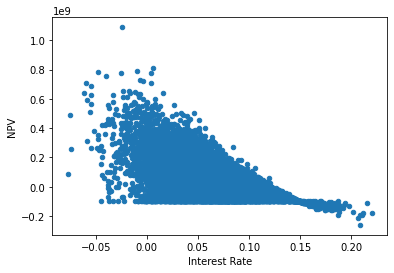

In [28]:
df.plot.scatter(x='Interest Rate', y='NPV')

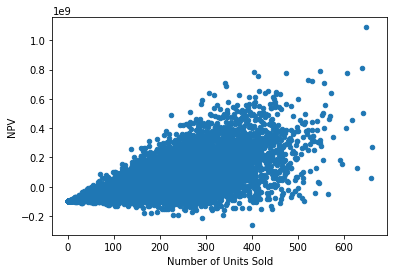

In [29]:
df.plot.scatter(x='Number of Units Sold', y='NPV')

Just based off looking at the scatter plots, it seems that interest rate does not have much of an effect, while number of units sold has a very direct relation with the NPV. Because of how different the plots are, this would be enough to conclude that number of units has a greater effect. But let's take it one step further to quantify the difference.

## Regressions

Note: this is an advanced section for additional learning. We don't have time to cover this in detail in the class so you won't be required to use it for any projects.

### Run the Regression

We can use `statsmodels` to run a multivariate regression to quantify the effects of interest rate and number of units on the NPV.

In [30]:
import statsmodels.api as sm

X = sm.add_constant(df[['Interest Rate', 'Number of Units Sold']])
y = df['NPV']

model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    NPV   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                 3.120e+04
Date:                Sat, 28 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:28:22   Log-Likelihood:            -1.9094e+05
No. Observations:               10000   AIC:                         3.819e+05
Df Residuals:                    9997   BIC:                         3.819e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4.174e+07   1.28e+06     32.676      0.000    3.92e+07    4.42e+07
Interest Rate        -2.058e+09    1.2e+07   -171.223      0.000   -2.08e+09   -2.03e+09
Number of Units Sold  7.412e+05   4118.286    179.977      0.000    7.33e+05    7.49e+05
==============================================================================
Omnibus:                     2492.586   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19994.168
Skew:                           0.973   Prob(JB):                         0.00
Kurtosis:                       9.648   Cond. No.                     5.94e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpret the Regression

#### One Unit Change

There we can see the coefficients under the `coef` column. We can also access them via `result.params`:

In [31]:
result.params

const                   4.173698e+07
Interest Rate          -2.058473e+09
Number of Units Sold    7.411950e+05
dtype: float64

In [32]:
result.params['Interest Rate']

-2058473116.3305802

In [33]:
print(f'Selling one additional unit leads to a ${result.params["Number of Units Sold"]:,.2f} change in NPV')

Selling one additional unit leads to a $741,195.00 change in NPV


Also notice that because I am using quotes inside quotes there, I have used single quotes for one and double quotes for the other to avoid conflicts.

We need to be careful about the interpretation of the interest rate. As we have it in decimal, a one unit change is a 100% change. So the value we see as the coefficient is the change in NPV for a 100% change in interest rate. To get to a 1% change in interest rate, we need to divide by 100.

In [34]:
print(f'A one percent increase in interest rate leads to a ${result.params["Interest Rate"]/100:,.2f} change in NPV')

A one percent increase in interest rate leads to a $-20,584,731.16 change in NPV


#### One Standard Deviation Change

Now we know which has a greater impact by unit. A 1% increase in interest rate has a larger impact that a 1 unit increase on the NPV. This doesn't sqaure up with what we saw in the scatter plots. Why?

Just looking at a one unit change ignores what a typical change is for the different inputs. The number of units sold here is changing around a lot more than the interest rate. So even though it has a smaller impact by unit, it could have a larger impact overall once we consider how much it is changing.

We can measure how much they are changing with the standard deviation, and compare the changes for a one standard deviation change in each input to get what a typical impact would be.

In [35]:
df["Number of Units Sold"].std()

115.26942543469194

In [36]:
df["Interest Rate"].std()

0.03948648536235224

We can see the standard deviation for number of units is much larger.

In [37]:
print(f'A one standard deviation increase in the number of units leads to a ${result.params["Number of Units Sold"] * df["Number of Units Sold"].std():,.2f} change in NPV')

A one standard deviation increase in the number of units leads to a $85,437,122.16 change in NPV


In [38]:
print(f'A one standard deviation increase in the interest rate leads to a ${(result.params["Interest Rate"] * df["Interest Rate"].std()) / 100:,.2f} change in NPV')

A one standard deviation increase in the interest rate leads to a $-812,818.69 change in NPV


## Putting the Analysis and Visualization Together

We just did a lot of things with the output. We will have to repeat this process for each plane simulation. So let's create a function to run all of this.

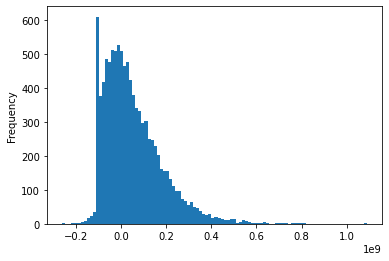

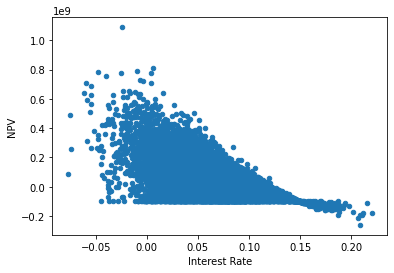

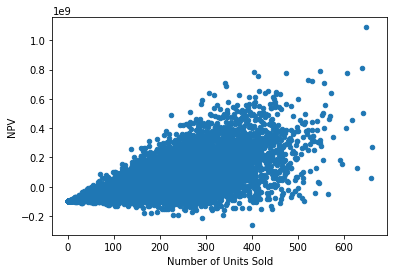

Probability Table


,Interest Rate,Number of Units Sold,NPV
0.05,0.4%,3,"$-100,000,000"
0.1,1.8%,47,"$-87,693,668"
0.15,2.8%,76,"$-71,309,161"
0.2,3.6%,101,"$-57,449,231"
0.25,4.2%,120,"$-43,569,431"
0.3,4.8%,138,"$-30,060,082"
0.35,5.4%,155,"$-17,163,479"
0.4,5.9%,171,"$-4,100,158"
0.45,6.4%,186,"$9,176,607"
0.5,6.9%,202,"$23,650,582"



The expected NPV is $50,829,037 with $127,729,724 standard deviation.

The chance of a positive NPV is 58.3% and the chance of a negative NPV is 41.7%

Regression Results
Selling one additional unit leads to a $741,195 change in NPV
A one percent increase in interest rate leads to a $-20,584,731 change in NPV
A one standard deviation increase in the number of units leads to a $85,437,122 change in NPV
A one standard deviation increase in the interest rate leads to a $-812,819 change in NPV


In [39]:
def simulation_plots(df):
    """
    Uses the simulation results create plots.
    
    Included plots:
    - Histogram of NPV probability distribution
    - Scatter plots of the relationships between:
        - Interest rate and NPV
        - Number of units sold and NPV
    """
    df['NPV'].plot.hist(bins=100)
    df.plot.scatter(x='Interest Rate', y='NPV')
    df.plot.scatter(x='Number of Units Sold', y='NPV')
    plt.show()  # show the plots as soon as this command is run
    
    
def probability_table(df):
    """
    Produces a table quantifying the probability distributions
    of the simulation inputs and resulting NPV.
    """
    return styled_df(df.quantile([i/20 for i in range(1, 20)]))


def expected_and_stdev_npv(df):
    """
    Calculates the average and standard deviation of the NPV 
    from the simulations.
    """
    mean = df['NPV'].mean()  # expected NPV
    std = df['NPV'].std()  # stdev of NPV
    return mean, std


def chance_of_positive_negative_npv(df):
    """
    Calculates the probabilities of a positive and negative NPV 
    based on the simulation data.
    """
    positive_npv_prob = ( df['NPV'] > 0 ).astype(int).mean()
    negative_npv_prob = 1 - positive_npv_prob
    return positive_npv_prob, negative_npv_prob


def simulation_regression(df):
    """
    Quantifies the relationship between the inputs and NPV
    in the simulation.
    """
    X = sm.add_constant(df[['Interest Rate', 'Number of Units Sold']])
    y = df['NPV']

    model = sm.OLS(y, X)
    result = model.fit()
    
    units_coef = result.params["Number of Units Sold"]
    units_std = df["Number of Units Sold"].std()
    units_std_effect = units_coef * units_std
    
    interest_coef = result.params["Interest Rate"] / 100
    interest_std = df["Interest Rate"].std()
    interest_std_effect = interest_coef * interest_std
    
    print(f'Selling one additional unit leads to a ${units_coef:,.0f} change in NPV')
    print(f'A one percent increase in interest rate leads to a ${interest_coef:,.0f} change in NPV')
    print(f'A one standard deviation increase in the number of units leads to a ${units_std_effect:,.0f} change in NPV')
    print(f'A one standard deviation increase in the interest rate leads to a ${interest_std_effect:,.0f} change in NPV')

    
def display_header(header):
    """
    Displays a formatted header, for separating results
    """
    display(HTML(f'<h2>{header}</h2>'))
    
    
def simulation_summary(df, plane):
    """
    Takes the simulation results and produces a full analysis and
    visualization of the results.
    """
    display_header(plane.name)
    simulation_plots(df)
    table = probability_table(df)
    mean, std = expected_and_stdev_npv(df)
    pos_chance, neg_chance = chance_of_positive_negative_npv(df)
    print('Probability Table')
    display(table)  # print won't work on Styler objects, use display
    print('')
    print(f'The expected NPV is ${mean:,.0f} with ${std:,.0f} standard deviation.')
    print('')
    print(f'The chance of a positive NPV is {pos_chance:.1%} and the chance of a negative NPV is {neg_chance:.1%}')
    print('')
    print('Regression Results')
    simulation_regression(df)
    
    
simulation_summary(df, plane)

# Running the Actual Simulations for Each Plane

Now we have a function which does the full simulation, visualization, and analysis process for a plane. Now we want to repeat this for each plane.

/home/nick/.local/share/virtualenvs/fin-model-course-eIFMSc8A/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: numpy.npv is deprecated and will be removed from NumPy 1.20. Use numpy_financial.npv instead (https://pypi.org/project/numpy-financial/).


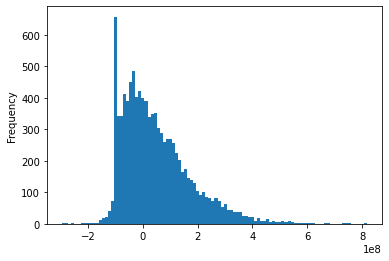

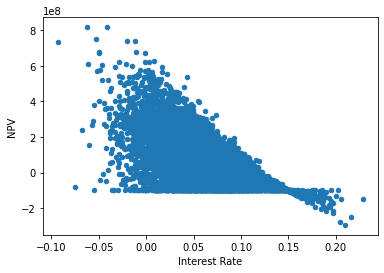

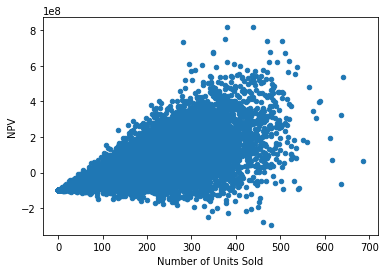

Probability Table


,Interest Rate,Number of Units Sold,NPV
0.05,0.3%,6,"$-100,000,000"
0.1,1.8%,49,"$-88,174,412"
0.15,2.8%,78,"$-72,487,059"
0.2,3.6%,100,"$-58,595,342"
0.25,4.3%,121,"$-44,640,500"
0.3,4.9%,138,"$-33,239,332"
0.35,5.4%,153,"$-20,701,599"
0.4,5.9%,169,"$-7,533,386"
0.45,6.4%,185,"$6,451,952"
0.5,7.0%,200,"$21,078,524"



The expected NPV is $48,758,097 with $126,611,218 standard deviation.

The chance of a positive NPV is 57.2% and the chance of a negative NPV is 42.8%

Regression Results
Selling one additional unit leads to a $725,431 change in NPV
A one percent increase in interest rate leads to a $-20,418,728 change in NPV
A one standard deviation increase in the number of units leads to a $83,448,299 change in NPV
A one standard deviation increase in the interest rate leads to a $-822,025 change in NPV


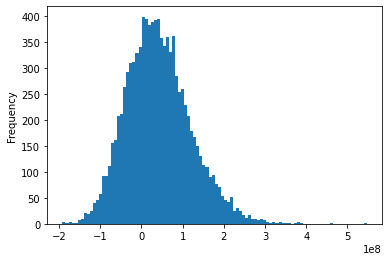

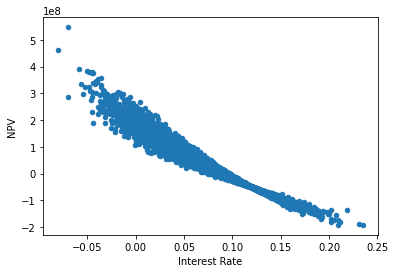

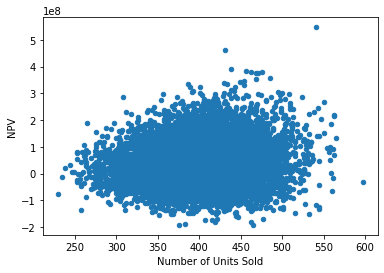

Probability Table


,Interest Rate,Number of Units Sold,NPV
0.05,0.4%,317,"$-75,554,445"
0.1,2.0%,336,"$-53,545,118"
0.15,2.9%,348,"$-37,618,629"
0.2,3.7%,357,"$-24,467,685"
0.25,4.4%,366,"$-13,068,124"
0.3,4.9%,374,"$-2,021,974"
0.35,5.5%,381,"$7,521,435"
0.4,6.0%,387,"$17,031,176"
0.45,6.5%,393,"$26,384,428"
0.5,7.0%,400,"$36,042,423"



The expected NPV is $41,718,213 with $78,290,563 standard deviation.

The chance of a positive NPV is 69.0% and the chance of a negative NPV is 31.0%

Regression Results
Selling one additional unit leads to a $222,784 change in NPV
A one percent increase in interest rate leads to a $-19,116,152 change in NPV
A one standard deviation increase in the number of units leads to a $11,061,776 change in NPV
A one standard deviation increase in the interest rate leads to a $-766,162 change in NPV


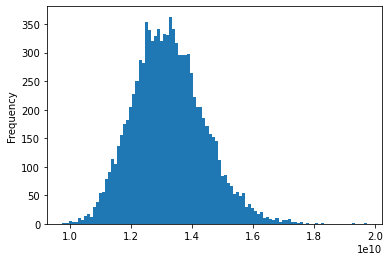

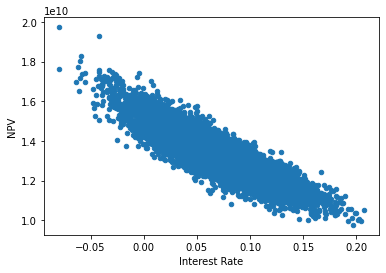

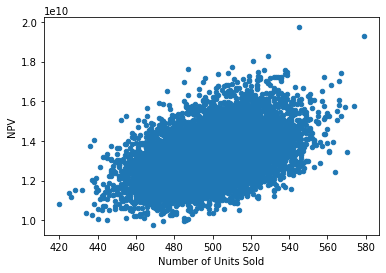

Probability Table


,Interest Rate,Number of Units Sold,NPV
0.05,0.5%,467,"$11,436,720,561"
0.1,2.0%,474,"$11,798,764,315"
0.15,2.9%,479,"$12,059,755,043"
0.2,3.7%,483,"$12,266,692,172"
0.25,4.4%,486,"$12,443,842,889"
0.3,4.9%,490,"$12,586,488,649"
0.35,5.5%,492,"$12,737,914,663"
0.4,6.0%,495,"$12,887,538,663"
0.45,6.6%,498,"$13,041,652,157"
0.5,7.1%,500,"$13,187,413,843"



The expected NPV is $13,250,436,079 with $1,171,203,537 standard deviation.

The chance of a positive NPV is 100.0% and the chance of a negative NPV is 0.0%

Regression Results
Selling one additional unit leads to a $26,665,584 change in NPV
A one percent increase in interest rate leads to a $-262,695,786 change in NPV
A one standard deviation increase in the number of units leads to a $536,646,509 change in NPV
A one standard deviation increase in the interest rate leads to a $-10,456,764 change in NPV


In [40]:
def all_plane_simulations(data):
    """
    Runs all the Monte Carlo simulations for each of the planes in the passed data.
    
    Visualizes and analyzes the simulations for each plane for the full presentation
    of the analysis.
    """
    for plane in data.planes:
        df = plane_simulations(model_data, plane)
        simulation_summary(df, plane)
        
all_plane_simulations(model_data)

# Observations

We can see that the expected NPV increases with the size of the plane, but so does the standard deviation of the NPV and the probability of getting a negative NPV. In other words, the larger planes are riskier but also offer higher returns. The ultimate choice of plane will depend on the risk tolerance of the manufacturer.

The distribution of the super size plane looks highly skewed to the left, because there is a reasonable chance of not selling any planes. Once you are not selling any planes, the NPV doesn't change much, just a bit due to the interest rate.

The scatter plot comparing NPV to interest rate looks odd for the super size plane because so many of the NPVs are negative. Using a lower interest rate will increase the NPV if it's negative and decrease it if it's positive.

Across the board, the number of units sold is a much more important factor than the interest rate. This makes sense because everything is happening in two years. If plane sales were spread across 10 or 15 years, we would see a larger impact of the interest rate.